# Introduction
This notebook is a result of a master's project in supervised learning.  Given the choice of topic, I initally veered directly towards climate change oriented work.  However, I stumbed upon the stop and frisk questionnaire dataset while perusing the NYC Open Data site.  After comparing some of the previous analysis from 2016, I found the line of inquiry much more compelling and fascinating from a social impact point of view.  

With an initial perusal of the data via pivot tables, I was just shocked that there are a disturbing number of disproportionate stops of black children and black individuals at large.  

Racially biased policing is a phrase that's almost redundant for the anti-racist individuals, so I'm not uncovering anything new here.  

But are these findings statistically significant?  Is this dataset truly representative of stop and frisk? Is there anything here in the data that might improve the lives of our NYC neighbors?  I may be asking these questions (and assuming their answers) as an average NYC resident, but I hope to answer them rigorously as a data scientist and as a machine learning engineer.  

As such, I decided to focus on a 2024 exploration of the NYPD generated dataset to find latent truths hidden in the data and attempt to train a predictive model which helps hold the NYPD accountable, but more importantly to provide tooling to aid those who are unjustly targeted.

## A Brief Aside for unexpected empathy
Having turned the corner on much of the EDA, I suddenly understand why officers are so reluctant to take actions because of the "paperwork".  

At 81 discrete data points which need to be vetted and validated, a couple of stop and frisk interactions can easily take up an entire afternoon of data entry.  I say this after seeing the [astronomical stop and frisk numbers prior to 2017](https://datacollaborativeforjustice.org/dashboard-sqf/) and reviewing the data from the same period.  There's orders of magnitude less data collected from that period despite a stop rate of up to 25k stops / 100,000 persons.  One of the primary drivers of keeping these rates as low as they are might very well be the raw data entry time required to process that many events.

But, I digress....

# EDA (Exploratory Data Analysis)
EDA is a method of exploring through a given set of data, finding and cleaning outliers, and ultimately preparing the data for ML model training.  In contrast to many public/open datasets, this dataset is fairly clean and consistent, possibly because of legal oversight.  

Regardless, I will thankfully be able to focus more on analyzing the data than fixing and cleaning it.

In [85]:
# Import all the things...
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import math

In [86]:
null_strings = ['(null)','#N/A', 'NA', '?', '', ' ', '&&', 'nan']

raw_df = pd.read_csv('./data/sqf-2024.csv',dtype={
        'STOP_FRISK_DATE': 'object',  # Keep as string
        'STOP_FRISK_TIME': 'object'   # Keep as string
    },
    na_values=null_strings,  # Standardize nulls
    low_memory=False)
raw_df.head()

,STOP_ID,STOP_FRISK_DATE,STOP_FRISK_TIME,YEAR2,MONTH2,DAY2,STOP_WAS_INITIATED,ISSUING_OFFICER_RANK,ISSUING_OFFICER_COMMAND_CODE,SUPERVISING_OFFICER_RANK,...,SUSPECT_OTHER_DESCRIPTION,STOP_LOCATION_PRECINCT,STOP_LOCATION_SECTOR_CODE,STOP_LOCATION_APARTMENT,STOP_LOCATION_FULL_ADDRESS,STOP_LOCATION_STREET_NAME,STOP_LOCATION_X,STOP_LOCATION_Y,STOP_LOCATION_PATROL_BORO_NAME,STOP_LOCATION_BORO_NAME
0,279772561,2024-01-01,01:58:00,2024,January,Monday,Based on Self Initiated,PO,46,SGT,...,NaN,46.0,A,NaN,1775 CLAY AVE,CLAY AVE,1010576.0,247603.0,PBBX,BRONX
1,279772564,2024-01-01,00:48:00,2024,January,Monday,Based on Self Initiated,PO,120,SGT,...,BLACK HOODIE SWEATSHIRT,67.0,D,NaN,4515 FARRAGUT RD,FARRAGUT RD,1002798.0,171482.0,PBBS,BROOKLYN
2,279772565,2024-01-01,01:10:00,2024,January,Monday,Based on Radio Run,PO,871,SGT,...,SCAR ON LIP,68.0,D,NaN,NaN,NaN,977764.0,170616.0,PBBS,BROOKLYN
3,279772566,2024-01-01,01:10:00,2024,January,Monday,Based on Radio Run,PO,871,SGT,...,RED JACKET/ RED HAT,68.0,D,NaN,NaN,NaN,977764.0,170616.0,PBBS,BROOKLYN
4,279772567,2024-01-01,01:10:00,2024,January,Monday,Based on Radio Run,PO,871,SGT,...,BLACK JACKET,68.0,D,NaN,NaN,NaN,977764.0,170616.0,PBBS,BROOKLYN


## And maybe I spoke too soon
As this dataset is pretty messy under the hood when it comes to specific datatypes.  This is relatively fine for human based consumption, but it will throw our model for a loop down the line during training.  As such, I'll first trim down the number of columns based on sparsity or irrelevance, and categorize them for uniform standardization.

In [87]:
# We have a number of broken columns which should by integer based, but contain null strings as well.  We'll clean those up if they make the final cut...
# broken_columns = [63,72,77,78]
# for v in broken_columns:
#     print(raw_df.columns[v])


# I'll come back to these columns later, but these will be transformed/hot-encoded later for training
# I'm omitting any background or suspects actions as those values should show up within the reason for the stop field, e.g.
# I will skip SUSPECTS_ACTIONS_CONCEALED_POSSESSION_WEAPON_FLAG because the corresonding rows have a criminal possession of a weapon reason already

categorical_columns_to_be_encoded = ['STOP_WAS_INITIATED']

column_categories = {
    'datetime': ['STOP_FRISK_DATE'],
    'numeric': ['STOP_ID', 'OBSERVED_DURATION_MINUTES', 'STOP_DURATION_MINUTES', 'SUSPECT_REPORTED_AGE',	'SUSPECT_WEIGHT', 'STOP_LOCATION_X',
                'STOP_LOCATION_Y'],
    'string': ['MONTH2', 'STOP_WAS_INITIATED', 'ISSUING_OFFICER_RANK', 'SUPERVISING_OFFICER_RANK', 'JURISDICTION_DESCRIPTION', 'SUSPECT_ARREST_OFFENSE',
               'SUMMONS_OFFENSE_DESCRIPTION', 'SUSPECTED_CRIME_DESCRIPTION',  'DEMEANOR_OF_PERSON_STOPPED', 'SUSPECT_SEX', 
               'SUSPECT_RACE_DESCRIPTION', 'SUSPECT_BODY_BUILD_TYPE', 'SUSPECT_OTHER_DESCRIPTION','STOP_LOCATION_BORO_NAME'
    ],
    'boolean': ['OFFICER_EXPLAINED_STOP_FLAG', 'OTHER_PERSON_STOPPED_FLAG', 'SUSPECT_ARRESTED_FLAG',
               'SUMMONS_ISSUED_FLAG', 'OFFICER_IN_UNIFORM_FLAG', 'FRISKED_FLAG',
               'SEARCHED_FLAG', 'ASK_FOR_CONSENT_FLG', 'CONSENT_GIVEN_FLG', 'OTHER_CONTRABAND_FLAG', 'FIREARM_FLAG', 'KNIFE_CUTTER_FLAG',
               'OTHER_WEAPON_FLAG', 'WEAPON_FOUND_FLAG', 'PHYSICAL_FORCE_CEW_FLAG', 'PHYSICAL_FORCE_DRAW_POINT_FIREARM_FLAG', 'PHYSICAL_FORCE_HANDCUFF_SUSPECT_FLAG',
               'PHYSICAL_FORCE_OC_SPRAY_USED_FLAG', 'PHYSICAL_FORCE_OTHER_FLAG', 'PHYSICAL_FORCE_RESTRAINT_USED_FLAG', 'PHYSICAL_FORCE_VERBAL_INSTRUCTION_FLAG',
               'PHYSICAL_FORCE_WEAPON_IMPACT_FLAG', 'SEARCH_BASIS_ADMISSION_FLAG',	'SEARCH_BASIS_CONSENT_FLAG',	'SEARCH_BASIS_HARD_OBJECT_FLAG',	
               'SEARCH_BASIS_INCIDENTAL_TO_ARREST_FLAG', 'SEARCH_BASIS_OTHER_FLAG',	'SEARCH_BASIS_OUTLINE_FLAG'],
    # One offs/unique cols
    'height': ['SUSPECT_HEIGHT'],
    'hours': ['STOP_FRISK_TIME'],
}
columns_to_keep = [column for category in column_categories.values() for column in category] 


def clean_numeric(df, cols):
    for col in cols:
        df[col] = (
            df[col]
            # .replace(null_strings, np.nan)
            .apply(pd.to_numeric, errors='coerce')  # Coerce non-numeric to NaN
            .astype('Int64')  # Convert to nullable integer
        )
    return df

def clean_string(df, cols):
    for col in cols:
        df[col] = (
            df[col]
            .astype(str)
            .replace(null_strings, np.nan)
            .str.strip()  # Remove leading/trailing whitespace
        )
    return df

def clean_boolean(df, cols):
    pd.set_option('future.no_silent_downcasting', True) # Future proofing
    for col in cols:
        value_counts = df[col].value_counts()
        # These are boolean fields, so we shouldn't see anything other than two options, whether null or false, but never both.
        if len(value_counts) < 2:  # Force features with only 'Y' values to have 'N' values instead of nulls
            df[col] = df[col].replace([np.nan], 'N')
        df[col] = (
            df[col]
            # .replace(null_strings, False)
            .str.strip()  # Remove leading/trailing whitespace
            .replace({'Y': True, 'N': False, '1': True, '0': False}).infer_objects(copy=False)
            .astype('boolean')  # Pandas' nullable boolean
        )
        num_null_values = df[col].isna().sum()
        assert num_null_values >= 0 if col in ['ASK_FOR_CONSENT_FLG','CONSENT_GIVEN_FLG'] else num_null_values == 0, f"{col}: {num_null_values} <NA> values"
    return df

def clean_datetime(df, cols):
    date_formats = {
        'STOP_FRISK_DATE': '%Y-%M-%d',  # YYYY-MM-DD
    }
    for col in cols:
        df[col] = pd.to_datetime(df[col], format=date_formats.get(col), errors='coerce')
    return df

def clean_hours(df, cols):
    for col in cols:
        df[col] = df[col].str.split(':').str[0]  # Parse out hours from HH:MM:SS format...
        df[col] = pd.to_numeric(df[col],  errors='coerce')
    return df

def clean_height(df, cols, null_strings=null_strings):
    for col in cols:
        df[col] = (
            df[col]
            .astype(str)
            # .replace(null_strings, np.nan)
            .str.extract(r'^(\d+)\.?(\d+)?$')  # Extract feet and inches
            .apply(lambda x: (int(x[0]) * 30.48) + (int(x[1]) * 2.54) if pd.notna(x[0]) else np.nan, axis=1)
            .round()
            .astype('Int64')
        )
    return df    
def filter_bad_data(df):
    # Completely arbitrary cut off for bad data, but I'll assume any ages less than 6 to be errors
    # Similarly, this may remove real, valid data for stops of developmentally disabled persons
    df = df.dropna(subset=['SUSPECT_REPORTED_AGE', 'SUSPECT_HEIGHT', 'SUSPECT_RACE_DESCRIPTION'])
    df = df[df['SUSPECT_REPORTED_AGE'] >= 6] 
    df = df[df['SUSPECT_HEIGHT'].between(90, 250)] # Min heights of 3ftm to a max of ~8ft
    return df

def clean_data(df, categories, columns_to_keep=columns_to_keep):
    new_df = df[columns_to_keep].copy()
    new_df = clean_datetime(new_df, categories['datetime'])
    new_df = clean_hours(new_df, categories['hours'])
    new_df = clean_string(new_df, categories['string'])
    new_df = clean_numeric(new_df, categories['numeric'])
    new_df = clean_boolean(new_df, categories['boolean'])
    new_df = clean_height(new_df, categories['height'])
    new_df = filter_bad_data(new_df)
    return new_df
cleaned_df = clean_data(raw_df, column_categories)
print(f'There is approximately {len(cleaned_df)/ len(raw_df)}% of the original data after cleaning')
# cleaned_df.head(20)


There is approximately 0.7996927440321437% of the original data after cleaning


## Ongoing Assumptions
Cleaning the data has been more laborious than expected, but I wanted to explicitly call out my subjective modifications.  In particular, I've noted that I'm omitting a number of columns up front due to sparcity (i.e. not enough data) and high correlation/duplicative values (WEAPON_FOUND_FLAG overlaps with the various arrest reason flags like SUSPECTS_ACTIONS_CONCEALED_POSSESSION_WEAPON_FLAG) that will throw off future training.

Similarly, a few of the boolean/flag fields actually contain three types of values due to null strings rather than the expected two.  Initially I was going to assume a false value for all null values here, but I felt it would alter the data too much/not provide enough benefits to modify those values given what they represent.  For transparency, the flags are ASK_FOR_CONSENT_FLG and CONSENT_GIVEN_FLG, with null values representing ~2.49% and 12.26% respectively.

Conversely, there are a number of flag fields which only contain Y values, so I'll be assuming that those null/missing values are indeed false.

In [88]:
# Given the range of clerical/data entry errors in the dataset, 
#   I wanted to filter out values too far outside the norm to ensure accurate exaluations of children facing cases.
def is_plausible_child(row):
    age = row['SUSPECT_REPORTED_AGE']
    height = row['SUSPECT_HEIGHT']
    
    if age >= 18:
        return True
    # Approximate CDC growth chart percentiles (translates roughly to heights of 92cm-120cm for 6 year olds, 139-210cm)
    expected_min = 2.5*age + 77  # ~1st percentile
    expected_max = 6.5*age + 100  # ~99th percentile
    
    return (height >= expected_min) & (height <= expected_max)

plausible_df = cleaned_df[
    (cleaned_df.apply(is_plausible_child, axis=1))
]
len(plausible_df) / len(cleaned_df)
print(f'{len(plausible_df) / len(cleaned_df)}% of data remains after age-height validation')
# 2.5*6 + 77, 2.5*17 + 77, 6.5*6+100, 6.5*17+100

0.999704448056746% of data remains after age-height validation


## Spar-city, here we come
We can see from the vast differences in null rates between the datasets that these flag features are incredibly sparse overall, so normalizing them enables usage of a much larger number of these fields.  That said, we still have some outlier features that I'll consider dropping as we more forwards, specifically weight.

Until then, let's just explore the data as is.

In [89]:
def sparsity_report(df):
    sparsity_report = pd.DataFrame({
        'column': df.columns,
        'null_rate': df.isnull().mean(),
        'unique_values': df.nunique()
    }).sort_values('null_rate', ascending=False)

    print(sparsity_report[['null_rate', 'unique_values']].head(20))
sparsity_report(raw_df)
sparsity_report(plausible_df)

                                                    null_rate  unique_values
PHYSICAL_FORCE_OC_SPRAY_USED_FLAG                    0.999961              1
PHYSICAL_FORCE_WEAPON_IMPACT_FLAG                    0.999567              1
ID_CARD_IDENTIFIES_OFFICER_FLAG                      0.999015              1
SUSPECTS_ACTIONS_IDENTIFY_CRIME_PATTERN_FLAG         0.995234              1
PHYSICAL_FORCE_CEW_FLAG                              0.995234              1
SUSPECTS_ACTIONS_DRUG_TRANSACTIONS_FLAG              0.991807              1
VERBAL_IDENTIFIES_OFFICER_FLAG                       0.987079              1
SUSPECTS_ACTIONS_LOOKOUT_FLAG                        0.987001              1
SHIELD_IDENTIFIES_OFFICER_FLAG                       0.984952              1
OTHER_WEAPON_FLAG                                    0.983771              1
SEARCH_BASIS_ADMISSION_FLAG                          0.981092              1
PHYSICAL_FORCE_OTHER_FLAG                            0.976404              1

## Aggregation at Spar-city
We can see that there still a great deal of sparse data even after the cleaning processes above.  In order to both preserve the data, but also provide more meaningful results, I will aggregate a number of columns/features.

Outcome of Stop: Categorical column with values of "ARRESTED", "SUMMONS ISSUED", and "Innocent/No Action Taken" which will be aggregated from their respective columns while innocent will be the default value in the absence of the others

Officers Used Physical Force: A Boolean feature aggregated from the many physical force features (drawing firearms, using restraint, etc.) 


In [ ]:
final_df = plausible_df.copy()
final_df['OUTCOME_OF_STOP'] = np.select(
    condlist=[
        final_df['SUSPECT_ARRESTED_FLAG'],  
        final_df['SUMMONS_ISSUED_FLAG']
    ],
    choicelist=['Arrested', 'Summoned'],
    default='No Charges Filed'
)

PHYSICAL_FORCE_COLUMNS = [
    'PHYSICAL_FORCE_CEW_FLAG',            # Conducted Energy Weapon (Taser)
    'PHYSICAL_FORCE_DRAW_POINT_FIREARM_FLAG',
    'PHYSICAL_FORCE_HANDCUFF_SUSPECT_FLAG',
    'PHYSICAL_FORCE_OC_SPRAY_USED_FLAG',  # Pepper spray
    'PHYSICAL_FORCE_OTHER_FLAG',
    'PHYSICAL_FORCE_RESTRAINT_USED_FLAG',
    # 'PHYSICAL_FORCE_VERBAL_INSTRUCTION_FLAG', # Omitting as this doesn't reflect the use of force, but a warning.  Also distorts the dataset...
    'PHYSICAL_FORCE_WEAPON_IMPACT_FLAG'
]

# Create aggregated force column (True if ANY force was used)
final_df['OFFICER_USED_FORCE'] = (
    final_df[PHYSICAL_FORCE_COLUMNS]
    .fillna(False)                # Treat missing values as no force
    .any(axis=1)                  # True if any force column is True
    .astype(bool)                 # Ensure boolean dtype
)

final_df['FORCE_TYPE'] = np.select(
    [
        final_df['PHYSICAL_FORCE_WEAPON_IMPACT_FLAG'],
        final_df['PHYSICAL_FORCE_DRAW_POINT_FIREARM_FLAG'],
        final_df['PHYSICAL_FORCE_CEW_FLAG'], 
        final_df['PHYSICAL_FORCE_OC_SPRAY_USED_FLAG'],
        final_df['PHYSICAL_FORCE_HANDCUFF_SUSPECT_FLAG'],
        final_df['PHYSICAL_FORCE_OTHER_FLAG'],
        # final_df['PHYSICAL_FORCE_VERBAL_INSTRUCTION_FLAG'],
        final_df['PHYSICAL_FORCE_RESTRAINT_USED_FLAG']
    ],
    [
        'Weapon Impact',
        'Firearm Drawn', 
        'Taser',
        'Pepper Spray',
        'Handcuffs',
        'Other Physical Force',
        # 'Verbal Commands', 
        'Restraint Used'
    ],
    default='No Force'
)

# Verification
final_df = final_df.reset_index(drop=True)

assert len(final_df['SUSPECT_ARRESTED_FLAG']) == len(final_df)
assert len(final_df['SUMMONS_ISSUED_FLAG']) == len(final_df)
assert final_df[['OUTCOME_OF_STOP']].notna().all().all(), "Null values detected"
print(final_df[['OUTCOME_OF_STOP']].value_counts())
print(final_df[['OFFICER_USED_FORCE']].value_counts())
print(final_df[['FORCE_TYPE']].value_counts())


OUTCOME_OF_STOP 
No Charges Filed    13259
Arrested             6299
Summoned              737
Name: count, dtype: int64
OFFICER_USED_FORCE
False                 15633
True                   4662
Name: count, dtype: int64
FORCE_TYPE          
No Force                15633
Handcuffs                2998
Firearm Drawn             584
Restraint Used            493
Other Physical Force      475
Taser                     103
Weapon Impact               8
Pepper Spray                1
Name: count, dtype: int64


## For the Children
Before analyzing the dataset at large, I did want to segment off the events targeted at children.  Children represent ~19.8% of the total NYC population as of the 2020 census, yet represent 16% of the overall stops.  Given the problems of stop and frisk, this number should be 0, but let's assume that the procedure is legitimate.  Superficially, you'd expect some 1:1ish ratio for any demographic assuming that there's a constant rate of crime for all individuals.  Clearly this assumption doesn't fit reality, but for the sake of argument and statistical clarity, we will assume its true.  

Well, that leads us to the first incongruity, in that young children aren't really committing crimes at equal levels as their older counterparts.  Specifically, while we have zero cases for children under 6, we actually begin to see a great deal of stop and frisk as early as 7 years old.  So to make the numbers a bit more aligned, I will calcuate the percentage of cases for children excluding 5 years old and below for both populations.  In general, rather than representing ~20% of NYC, 6-17 year olds comprise ~14% of the city, edging them towards the terrain of being overpoliced given that they are 15% of the city, but represent 16% of the stop and frisk events. 

In [91]:
number_of_nyc_children = 1740142
number_of_children_under_5 = 475637
total_nyc_population = 8804190
percentage_of_children_in_nyc = (number_of_nyc_children ) / (total_nyc_population ) * 100
percentage_of_6_to_17_children = (number_of_nyc_children - number_of_children_under_5) / (total_nyc_population - number_of_children_under_5) * 100
print(f"6-17 year olds represent {percentage_of_6_to_17_children:.2f}% of all New Yorkers vs the percentage of all children in NYC: {percentage_of_children_in_nyc:.2f}% ")

6-17 year olds represent 15.18% of all New Yorkers vs the percentage of all children in NYC: 19.76% 


In [92]:
# For the children, prepping children specific dataframes for analysis
demographic_features = [
    'SUSPECT_REPORTED_AGE', 
    'SUSPECT_RACE_DESCRIPTION',
    'STOP_WAS_INITIATED',
    'SUSPECTED_CRIME_DESCRIPTION',
    'OFFICER_EXPLAINED_STOP_FLAG',
    'OUTCOME_OF_STOP',
    'FORCE_TYPE',
    # 'SUSPECT_HEIGHT',
    # 'SUSPECT_SEX',
    'STOP_LOCATION_BORO_NAME',
]
demographic_df = final_df[demographic_features].copy()

all_children_df = demographic_df[demographic_df['SUSPECT_REPORTED_AGE'] < 18].copy()
under_13_df = demographic_df[demographic_df['SUSPECT_REPORTED_AGE'] <= 12].copy()
under_13_df['SUSPECT_REPORTED_AGE'].value_counts()
 
print(f'{len(all_children_df)} total records of children targeted stops, where children comprise {len(all_children_df) / len(demographic_df)*100:.2f}% of all stops')

3263 total records of children targeted stops, where children comprise 16.08% of all stops


In [93]:
from pandas import DataFrame

# Create summary tables
def show_demographic_table(demo_table: DataFrame, title, index_title=""):  
    # Calculate row and colm totals for percentage calcs...
    demo_table['ROW TOTAL'] = demo_table.sum(axis=1)
    col_totals = pd.DataFrame([demo_table.sum()], index=['TOTAL'])
   
    # Calculate percentages
    grand_total = demo_table['ROW TOTAL'].sum()
    col_pct = pd.DataFrame([(demo_table.sum() / grand_total * 100).round(1)], index=['% OF TOTAL'])
   
    # Combine all components
    final_table = pd.concat([demo_table, col_totals, col_pct])
    final_table.rename_axis(columns=None)
    
    # Apply styling
    # final_table.index.name = index_title
    styled = final_table.style.set_caption(title)
    
    
    # Format only numeric cells with integers (avoiding the percentage row)
    styled = styled.format('{:,}', subset=pd.IndexSlice[demo_table.index.tolist() + ['TOTAL'], :])
    
    # Format percentage row
    styled = styled.format('{:.1f}%', subset=pd.IndexSlice['% OF TOTAL', :])
    
    # Add other styling
    styled = styled.background_gradient(cmap='Blues', subset=pd.IndexSlice[demo_table.index, :])
    styled = styled.set_table_styles([
        {'selector': 'tr:nth-last-child(2)', 'props': 'border-top: 2px solid black;'},
        {'selector': 'tr:last-child', 'props': 'border-top: 1px solid black;'},
        {'selector': '.row_heading', 'props': 'text-align: left;'},
        {'selector': 'caption', 'props': 'caption-side: top; font-size: 1.2em; font-weight: bold;'}
    ])
    # styled = styled.highlight_max(axis=0, subset=pd.IndexSlice[demo_table.index, :], color='#ffeb99')
    return styled

under_13_demo_table = (
    under_13_df.groupby(['SUSPECT_REPORTED_AGE', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
)
show_demographic_table(under_13_demo_table, "All Stops of Children under 13 by Age and Race", 'Age / Suspect')
# create_demo_table(plausible_df, "All Stops by Age and Race")

SUSPECT_RACE_DESCRIPTION,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
7,0.0,0.0,0.0,0.0,1.0,0.0,1.0
8,0.0,0.0,0.0,0.0,1.0,0.0,1.0
9,0.0,1.0,0.0,0.0,0.0,0.0,1.0
10,0.0,2.0,0.0,0.0,0.0,1.0,3.0
11,1.0,11.0,2.0,0.0,3.0,3.0,20.0
12,0.0,39.0,3.0,1.0,6.0,9.0,58.0
TOTAL,1.0,53.0,5.0,1.0,11.0,13.0,84.0
% OF TOTAL,1.2%,63.1%,6.0%,1.2%,13.1%,15.5%,100.0%


### Glossary of Police Terms 
Surprisingly, there is no official NYPD documentation for these values that I could find, even in its data dictionary.  Moreover, these code have changed over time in the stop and frisk datasets themselves.  As such, this is the best that I could glean from searching more broadly for reader transparency.

- Based on C/W on Scene: Based upon a complaint/witness or other third party
- Based on Radio Run: Officer was dispatched to investigate by headquarters
- Based on Self Initiated:  Officer initiated the stop and frisk interaction

In [94]:
under_13_demo_table = (
    under_13_df.groupby(['STOP_WAS_INITIATED', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
)
show_demographic_table(under_13_demo_table, "What inititated the stop of Children under 13 by Age and Race")

SUSPECT_RACE_DESCRIPTION,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
Based on C/W on Scene,0.0,12.0,1.0,0.0,1.0,1.0,15.0
Based on Radio Run,0.0,32.0,3.0,0.0,10.0,9.0,54.0
Based on Self Initiated,1.0,9.0,1.0,1.0,0.0,3.0,15.0
TOTAL,1.0,53.0,5.0,1.0,11.0,13.0,84.0
% OF TOTAL,1.2%,63.1%,6.0%,1.2%,13.1%,15.5%,100.0%


In [95]:
under_13_demo_table = (
    under_13_df.groupby(['SUSPECTED_CRIME_DESCRIPTION', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
)
show_demographic_table(under_13_demo_table, "Why Did Officers Stop Children under 13 by Age and Race")

SUSPECT_RACE_DESCRIPTION,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
ASSAULT,0.0,5.0,1.0,1.0,1.0,2.0,10.0
BURGLARY,1.0,3.0,0.0,0.0,0.0,0.0,4.0
CPW,0.0,11.0,3.0,0.0,7.0,1.0,22.0
CRIMINAL MISCHIEF,0.0,2.0,0.0,0.0,1.0,1.0,4.0
CRIMINAL TRESPASS,0.0,0.0,0.0,0.0,0.0,2.0,2.0
GRAND LARCENY,0.0,3.0,0.0,0.0,0.0,1.0,4.0
GRAND LARCENY AUTO,0.0,1.0,0.0,0.0,1.0,0.0,2.0
MENACING,0.0,3.0,1.0,0.0,0.0,0.0,4.0
OTHER,0.0,1.0,0.0,0.0,0.0,0.0,1.0
PETIT LARCENY,0.0,4.0,0.0,0.0,0.0,0.0,4.0


In [96]:
under_13_df 

# under_13_demo_table = (
#     under_13_df.groupby(['SUSPECTED_CRIME_DESCRIPTION', 'SUSPECT_RACE_DESCRIPTION'])
#     .size()
#     .unstack()
#     .fillna(0)
#     .astype(int)
# )
# show_demographic_table(under_13_demo_table, "Why Did Officers Stop Children under 13 by Age and Race")

,SUSPECT_REPORTED_AGE,SUSPECT_RACE_DESCRIPTION,STOP_WAS_INITIATED,SUSPECTED_CRIME_DESCRIPTION,OFFICER_EXPLAINED_STOP_FLAG,OUTCOME_OF_STOP,FORCE_TYPE,STOP_LOCATION_BORO_NAME
349,12,BLACK,Based on C/W on Scene,ROBBERY,True,No Charges Filed,Restraint Used,BRONX
534,10,WHITE HISPANIC,Based on Radio Run,CRIMINAL MISCHIEF,True,No Charges Filed,No Force,BROOKLYN
1487,12,BLACK,Based on C/W on Scene,PETIT LARCENY,True,No Charges Filed,No Force,BRONX
2508,12,WHITE,Based on Radio Run,CPW,True,No Charges Filed,No Force,STATEN ISLAND
2509,11,WHITE,Based on Radio Run,CPW,True,No Charges Filed,No Force,STATEN ISLAND
...,...,...,...,...,...,...,...,...
19422,11,BLACK,Based on Radio Run,ASSAULT,True,No Charges Filed,No Force,BROOKLYN
19968,9,BLACK,Based on Radio Run,ROBBERY,True,Arrested,No Force,QUEENS
19969,12,BLACK,Based on Radio Run,ROBBERY,True,No Charges Filed,No Force,QUEENS
19970,12,BLACK,Based on Radio Run,ROBBERY,True,Arrested,No Force,QUEENS


In [97]:
# print("Unique values in OFFICER_USED_FORCE:", under_13_df['OFFICER_USED_FORCE'].unique())
# print("Unique values in SUSPECT_RACE_DESCRIPTION:", under_13_df['SUSPECT_RACE_DESCRIPTION'].unique())


under_13_demo_table = (
    under_13_df.groupby(['FORCE_TYPE', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
)
show_demographic_table(under_13_demo_table, "Why Did Officers Stop Children under 13 by Age and Race")

SUSPECT_RACE_DESCRIPTION,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
Firearm Drawn,0.0,1.0,0.0,0.0,0.0,1.0,2.0
Handcuffs,0.0,9.0,1.0,0.0,1.0,2.0,13.0
No Force,1.0,42.0,4.0,1.0,10.0,10.0,68.0
Restraint Used,0.0,1.0,0.0,0.0,0.0,0.0,1.0
TOTAL,1.0,53.0,5.0,1.0,11.0,13.0,84.0
% OF TOTAL,1.2%,63.1%,6.0%,1.2%,13.1%,15.5%,100.0%


In [98]:
under_13_demo_table = (
    under_13_df.groupby(['OUTCOME_OF_STOP', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
)
show_demographic_table(under_13_demo_table, "What Were the Outcomes of Stops of Children under 13 by Age and Race")

SUSPECT_RACE_DESCRIPTION,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
Arrested,0.0,27.0,0.0,0.0,1.0,1.0,29.0
No Charges Filed,1.0,26.0,5.0,1.0,10.0,12.0,55.0
TOTAL,1.0,53.0,5.0,1.0,11.0,13.0,84.0
% OF TOTAL,1.2%,63.1%,6.0%,1.2%,13.1%,15.5%,100.0%


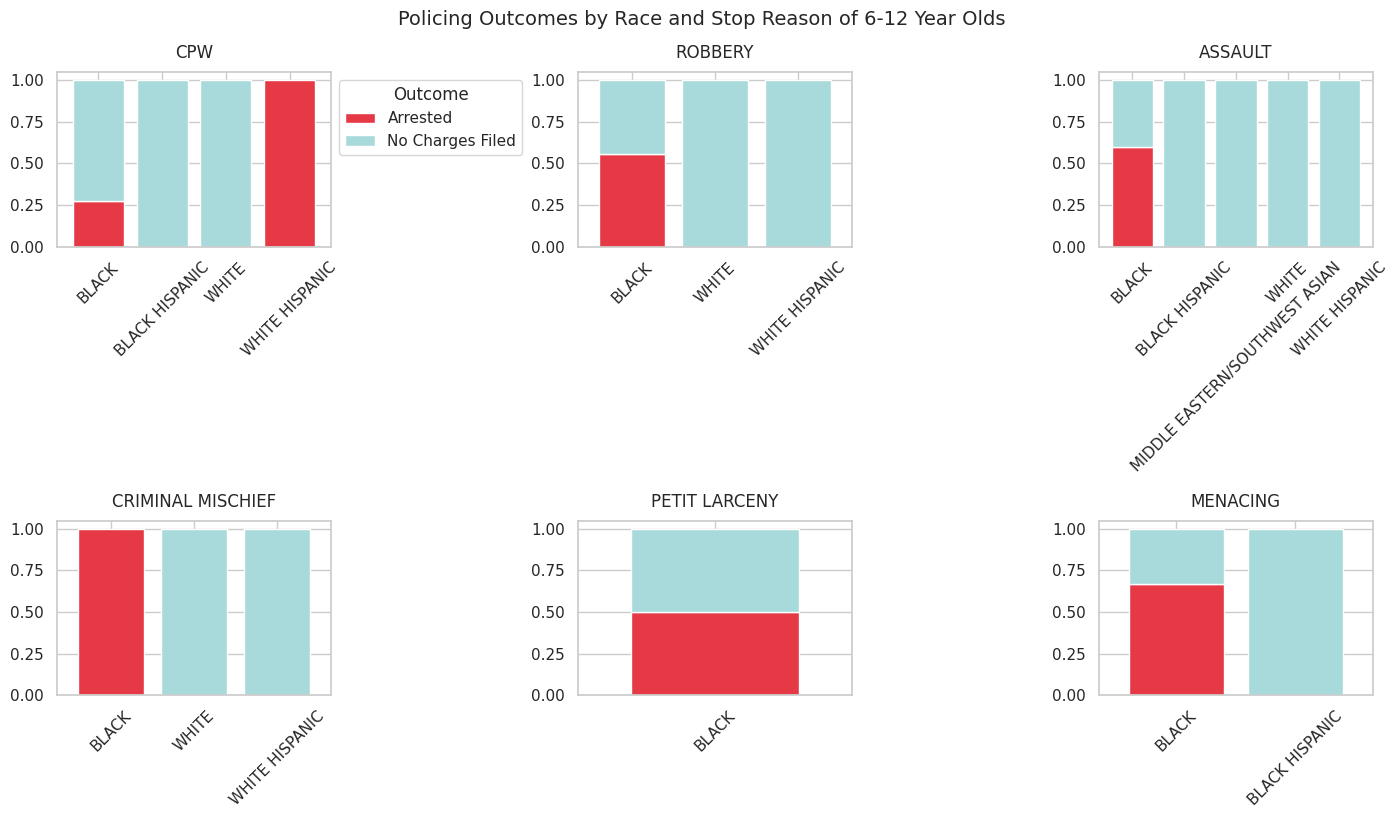

In [99]:

def plot_stop_outcomes(df, n_reasons=5, figsize=(14, 8)):
    # 1. Aggregate data safely
    outcomes = (
        df.groupby(['SUSPECT_RACE_DESCRIPTION', 
                   'SUSPECTED_CRIME_DESCRIPTION', 
                   'OUTCOME_OF_STOP'])
        .size()
        .unstack()
        .fillna(0)
    )
    
    # 2. Get top reasons that actually exist in data
    valid_reasons = df['SUSPECTED_CRIME_DESCRIPTION'].value_counts().nlargest(n_reasons).index
    valid_reasons = [r for r in valid_reasons if r in outcomes.index.get_level_values(1)]
    
    # 3. Set up plot
    n_cols = min(3, len(valid_reasons))
    n_rows = (len(valid_reasons) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
    
    # 4. Color palette for whatever outcomes exist
    palette = {
        'Arrested': '#e63946',
        'Summoned': '#457b9d', 
        'No Charges Filed': '#a8dadc',
        'Other': '#1d3557'  # Fallback
    }
    
    # 5. Plot each reason
    for i, reason in enumerate(valid_reasons):
        ax = axes[i]
        reason_data = outcomes.xs(reason, level='SUSPECTED_CRIME_DESCRIPTION')
        
        # Normalize and get ACTUAL existing outcomes
        reason_data = reason_data.div(reason_data.sum(axis=1), axis=0)
        existing_outcomes = [col for col in reason_data.columns if reason_data[col].sum() > 0]
        
        # Dynamically plot available outcomes
        reason_data[existing_outcomes].plot(
            kind='bar',
            stacked=True,
            ax=ax,
            color=[palette.get(o, '#999999') for o in existing_outcomes],
            width=0.8
        )
        
        # Formatting
        ax.set_title(f"{reason[:20]}..." if len(reason) > 20 else reason, pad=10)
        ax.set_ylabel("")
        ax.set_xlabel("")
        ax.tick_params(axis='x', rotation=45)
        
        # Only show legend on first plot
        if i != 0:
            ax.get_legend().remove()
        else:
            ax.legend(title='Outcome', bbox_to_anchor=(1, 1))

    # Clean up empty subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.suptitle("Policing Outcomes by Race and Stop Reason of 6-12 Year Olds", y=1.02, fontsize=14)
    plt.show()

# Usage
plot_stop_outcomes(under_13_df, n_reasons=6)

In [100]:
all_children_demo_table = (
    all_children_df.groupby(['SUSPECT_REPORTED_AGE', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
)
show_demographic_table(all_children_demo_table, "All Stops of Children by Age and Race")

# all_children_demo_table = (
#     all_children_df.groupby(['OUTCOME_OF_STOP', 'SUSPECT_RACE_DESCRIPTION'])
#     .size()
#     .unstack()
#     .fillna(0)
#     .astype(int)
# )
# show_demographic_table(all_children_demo_table, "All Stops of Children by Age and Race")

SUSPECT_RACE_DESCRIPTION,AMERICAN INDIAN/ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
7,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
8,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
10,0.0,0.0,2.0,0.0,0.0,0.0,1.0,3.0
11,0.0,1.0,11.0,2.0,0.0,3.0,3.0,20.0
12,0.0,0.0,39.0,3.0,1.0,6.0,9.0,58.0
13,0.0,2.0,151.0,11.0,6.0,13.0,32.0,215.0
14,2.0,2.0,329.0,28.0,4.0,32.0,77.0,474.0
15,0.0,20.0,470.0,72.0,9.0,24.0,137.0,732.0
16,0.0,8.0,566.0,75.0,7.0,26.0,157.0,839.0


In [101]:
all_children_demo_table = (
    all_children_df.groupby(['STOP_WAS_INITIATED', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
)
show_demographic_table(all_children_demo_table, "All Stops of Children by Age and Race")

SUSPECT_RACE_DESCRIPTION,AMERICAN INDIAN/ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
Based on C/W on Scene,0.0,8.0,197.0,36.0,3.0,14.0,78.0,336.0
Based on Radio Run,3.0,28.0,999.0,138.0,29.0,99.0,265.0,"1,561.0"
Based on Self Initiated,0.0,13.0,975.0,108.0,3.0,27.0,240.0,"1,366.0"
TOTAL,3.0,49.0,"2,171.0",282.0,35.0,140.0,583.0,"3,263.0"
% OF TOTAL,0.1%,1.5%,66.5%,8.6%,1.1%,4.3%,17.9%,100.0%


In [102]:
# Temp analysis

under_13_df[['SUSPECT_REPORTED_AGE', 'SUSPECT_RACE_DESCRIPTION', 'SUSPECTED_CRIME_DESCRIPTION', 'STOP_WAS_INITIATED', 'OFFICER_EXPLAINED_STOP_FLAG', 'STOP_LOCATION_BORO_NAME']].sort_values("SUSPECT_REPORTED_AGE", ascending=True)

,SUSPECT_REPORTED_AGE,SUSPECT_RACE_DESCRIPTION,SUSPECTED_CRIME_DESCRIPTION,STOP_WAS_INITIATED,OFFICER_EXPLAINED_STOP_FLAG,STOP_LOCATION_BORO_NAME
2512,7,WHITE,CPW,Based on Radio Run,True,STATEN ISLAND
2511,8,WHITE,CPW,Based on Radio Run,True,STATEN ISLAND
19968,9,BLACK,ROBBERY,Based on Radio Run,True,QUEENS
534,10,WHITE HISPANIC,CRIMINAL MISCHIEF,Based on Radio Run,True,BROOKLYN
17510,10,BLACK,OTHER,Based on Radio Run,True,BRONX
...,...,...,...,...,...,...
3393,12,BLACK,ROBBERY,Based on Self Initiated,True,MANHATTAN
10195,12,MIDDLE EASTERN/SOUTHWEST ASIAN,ASSAULT,Based on Self Initiated,True,BRONX
10517,12,BLACK,ROBBERY,Based on Radio Run,True,BROOKLYN
6996,12,BLACK,BURGLARY,Based on Radio Run,True,BROOKLYN


### The beginning of many "interesting" facts
Thankfully, there are very few stops of pre-teens, but it is still too high.  Surprising to me, the youngest two stop and frisk targets look to be a 7 and an 8 year old on Staten Island both for criminal possession of a weapon (CPW). Also, positively, there's only two cases in which the police failed to identify a reason for a stop.

...but we already see pretty skewed and disproporionate policing of black youth starting around 11 years old.  

TODO: add population stats for comparison, add new column for action taken as a fusion of summons + arrest 

# Misc Notes/Parking Lot
- Menacing filter is quite disproportionate

In [103]:
# Scratch
raw_df["SUSPECT_RACE_DESCRIPTION"].value_counts()

SUSPECT_RACE_DESCRIPTION
BLACK                             14662
WHITE HISPANIC                     5177
BLACK HISPANIC                     2485
WHITE                              1367
ASIAN / PACIFIC ISLANDER            435
MIDDLE EASTERN/SOUTHWEST ASIAN      228
AMERICAN INDIAN/ALASKAN NATIVE       41
Name: count, dtype: int64

# References
1. Research
    1. [NYCLU Stop and Frisk Dataset](https://www.nyclu.org/data/stop-and-frisk-data)
        1. [NYCLU Stop and Frisk Analysis regarding children](https://www.nyclu.org/data/closer-look-stop-and-frisk-nyc)
    1. [John Jay College of Criminal Justice](https://datacollaborativeforjustice.org/research-resources/)
1. Data
    1. [Stop and Frisk Dataset](https://data.cityofnewyork.us/Public-Safety/The-Stop-Question-and-Frisk-Data/ftxv-d5ix/about_data)
    1. [NYC Demographic Data](https://www.nyc.gov/content/planning/pages/resources/datasets/american-community-survey)
    1. [NYC Population Statistics](https://popfactfinder.planning.nyc.gov/explorer/cities/NYC?censusTopics=populationSexAgeDensity)
    1. [CDC Growth Charts](https://www.cdc.gov/growthcharts/data/set1clinical/cj41c021.pdf)
1. Misc.
    1. [Previous analysis and predictive model training from 2020](https://github.com/VeeLeeKoh/Stop-and-Frisk-Data-Analysis/) 